# Evaluation of GPU memory consumption for CUDA Tensors

In [1]:
import os
from datetime import datetime

import pandas as pd

## Data loading

At first, we specify the paths necessary for evaluation. This includes:
- the ocp metrics directory stored in `ocp_metrics_path`
- the directory `directory` for the specific model/series of runs we would like to consider
- the runs `runs` as a `dict` with shorter name as key and the respective csv filenames without "_resources/..." extensions

In [2]:
ocp_metrics_path = "/Users/danielherbst/Desktop/ocp-metrics"
directory = "s2ef/gemnet_xl/batch_size_1_grad_acc_2"
runs = {
    "stage0":                                           "1658747179_stage0_8gpus",
    "stage0_fp16":                                      "1658781353_stage0_8gpus_fp16",
    "stage2":                                           "1658785954_stage2_8gpus",
    "stage2_offloadOptimizer[cpu]":                     "1658756751_stage2_8gpus_offloadOptimizer[cpu]",
    "stage3_offloadOptimizer[cpu]_offloadParam[cpu]":   "1658805958_stage3_8gpus_offloadOptimizer[cpu]_offloadParam[cpu]"
}

In [3]:
def get_paths(runs, csv_type) -> dict:
    """
    runs:       dict of runs with timestamp
    directory:  directory in which the runs are stored
    sv_type:    ["resources"|"torch_cuda"] 
    TODO: add support for runtimes
    """
    if csv_type == "resources":
        return {key: os.path.join(ocp_metrics_path, directory, f"{run}_resources.csv") for key, run in runs.items()}
    elif csv_type == "torch_cuda":
        return {key: os.path.join(ocp_metrics_path, directory, f"{run}_torch_cuda.csv") for key, run in runs.items()}
    else:
        raise ValueError(f"CSV type {csv_type} is not supported.")

def get_metrics_csv(file_path, csv_type) -> pd.DataFrame:
    """
    file_path:  path to the metrics csv file within the ocp metrics folder
    csv_type:   ["resources"|"torch_cuda"]
    TODO: add support for runtimes
    """
    df = pd.read_csv(os.path.join(ocp_metrics_path, file_path))
    if csv_type == "resources":
        for header in ["memory_used", "memory_free"]:
            df[header] = df[header] / 1_000_000
    elif csv_type == "torch_cuda":
        for header in ["gpu_memory_allocated", "gpu_memory_reserved"]:
            df[header] = df[header] / 1_000_000
    else:
        raise ValueError(f"CSV type {csv_type} is not supported.")
    return df

In [4]:
resources_paths = get_paths(runs, csv_type="resources")
torch_cuda_paths = get_paths(runs, csv_type="torch_cuda")

## Inspection of a single run

At first, we inspect single runs with a set DeepSpeed configuration. We look at statistical summaries of the allocated and reserved memory.

In [5]:
cuda_df = get_metrics_csv(torch_cuda_paths["stage0"], csv_type="torch_cuda")
cuda_df

,datetime,epoch,rank,gpu_memory_allocated,gpu_memory_reserved
0,2022-07-25 11:06:22.190959,0,4,2367.652864,2562.719744
1,2022-07-25 11:06:22.191030,0,1,2367.652864,2562.719744
2,2022-07-25 11:06:22.191408,0,6,2367.652864,2562.719744
3,2022-07-25 11:06:22.191515,0,7,2367.652864,2562.719744
4,2022-07-25 11:06:22.191631,0,5,2367.652864,2562.719744
...,...,...,...,...,...
199995,2022-07-25 13:21:21.748784,0,7,7116.325888,37163.630592
199996,2022-07-25 13:21:21.769266,0,4,7103.796736,43171.971072
199997,2022-07-25 13:21:21.774509,0,5,7142.106624,44044.386304
199998,2022-07-25 13:21:21.825901,0,2,7092.009984,30643.585024


In [6]:
def cuda_memory_summary_per_gpu(cuda_df) -> pd.DataFrame:
    """
    Returns statistical summary of the cuda memory usage per rank.
    """
    return cuda_df.groupby("rank")[["gpu_memory_allocated", "gpu_memory_reserved"]].describe()

def cuda_memory_summary_averaged(cuda_df) -> pd.DataFrame:
    """
    Returns statistical summary of the cuda memory usage averaged over all ranks.
    """
    return cuda_df[["gpu_memory_allocated", "gpu_memory_reserved"]].describe()

In [7]:
cuda_memory_summary_per_gpu(cuda_df)

gpu_memory_allocated                                                    \
                    count         mean        std          min          25%   
rank                                                                          
0                 25000.0  7105.849893  29.968224  2367.652864  7106.006528   
1                 25000.0  7095.856627  29.905022  2367.652864  7096.010752   
2                 25000.0  7091.740169  29.878985  2367.652864  7091.895296   
3                 25000.0  7102.927672  29.949748  2367.652864  7103.079936   
4                 25000.0  7103.609622  29.954092  2367.652864  7103.751168   
5                 25000.0  7141.889834  30.196182  2367.652864  7142.042624   
6                 25000.0  7111.396349  30.003309  2367.652864  7111.550464   
7                 25000.0  7116.125178  30.033224  2367.652864  7116.276736   

                                            gpu_memory_reserved                \
              50%          75%          max               count          mean   
rank                                                                            
0     7106.038784  7106.071552  7106.244608             25000.0  36599.870249   
1     7096.045056  7096.079360  7096.243200             25000.0  37944.071364   
2     7091.927552  7091.961856  7092.101120             25000.0  29599.837675   
3     7103.118848  7103.152128  7103.331840             25000.0  36205.738213   
4     7103.794176  7103.840768  7104.025088             25000.0  42124.843449   
5     7142.078464  7142.116352  7142.319616             25000.0  39549.244843   
6     7111.585792  7111.621248  7111.795200             25000.0  44723.314098   
7     7116.315136  7116.351488  7116.523520             25000.0  36632.327115   

                                                                          \
              std          min           25%           50%           75%   
rank                                                                       
0     3297.506880  2562.719744  33619.443712  38587.596800  38587.596800   
1     2277.630726  2562.719744  38791.020544  38791.020544  38791.020544   
2     1366.070744  2562.719744  28003.270656  30643.585024  30643.585024   
3     2893.505504  2562.719744  35657.875456  35657.875456  38648.414208   
4     1970.505347  2562.719744  39860.568064  43171.971072  43171.971072   
5     2801.401910  2562.719744  37669.044224  40850.423808  40850.423808   
6     3280.865130  2562.719744  43079.696384  46066.040832  46066.040832   
7     1443.623741  2562.719744  37163.630592  37163.630592  37163.630592   

                    
               max  
rank                
0     38587.596800  
1     38791.020544  
2     30643.585024  
3     38648.414208  
4     43171.971072  
5     44044.386304  
6     46066.040832  
7     37163.630592

In [8]:
cuda_memory_summary_averaged(cuda_df)

,gpu_memory_allocated,gpu_memory_reserved
count,200000.000000,200000.000000
mean,7108.674418,37922.405876
std,33.311145,4912.520713
min,2367.652864,2562.719744
25%,7096.218368,35657.875456
50%,7104.021504,38587.596800
75%,7111.774592,40850.423808
max,7142.319616,46066.040832


For a single run, the GPU CUDA torch memory consumption can be plotted versus time, individually on each GPU or averaged/summed across all involved GPUs.

In [9]:
def plot_cuda_memory(cuda_df, mode="individual"):
    """
    Plot the GPU memory allocated by or reserved for Cuda tensors over time.

    mode:
        "individual":   Plot memory consumption for each rank individually.
        "averaged":     Plot memory consumption averaged over the GPUs.
        "sum":          Plot total memory consumption summed up over all GPUs.
    """
    if mode == "individual":
        cuda_plot_df = cuda_df.set_index("datetime")
        cuda_plot_df.index = pd.to_datetime(cuda_plot_df.index).strftime("%H:%M")
        for rank, group in cuda_plot_df.groupby("rank"):
            group[["gpu_memory_allocated", "gpu_memory_reserved"]].plot(
                xlabel="time", 
                ylabel="memory in MB",
                title=f"Rank {rank} GPU memory"
            )
    if mode in ["averaged", "sum"]:
        cuda_df_aggr = sum([
            cuda_df[cuda_df["rank"] == rank].reset_index(drop=True)[["gpu_memory_allocated", "gpu_memory_reserved"]]
            for rank in cuda_df["rank"].unique()
        ])
        cuda_df_aggr.index = pd.to_datetime(cuda_df[cuda_df["rank"] == 0].set_index("datetime").index).strftime("%H:%M")
        if mode == "averaged":
            cuda_df_aggr = cuda_df_aggr / cuda_df["rank"].nunique()
            title = "Averaged GPU memory"
        elif mode == "sum":
            title = "Total GPU memory"
        cuda_df_aggr.plot(
            xlabel="time",
            ylabel="memory in MB",
            title=title
        )

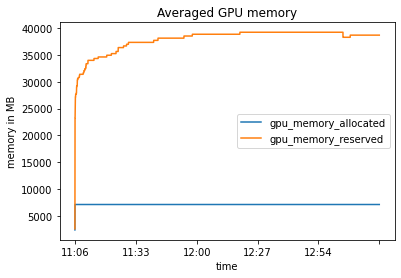

In [10]:
plot_cuda_memory(cuda_df, mode="averaged")

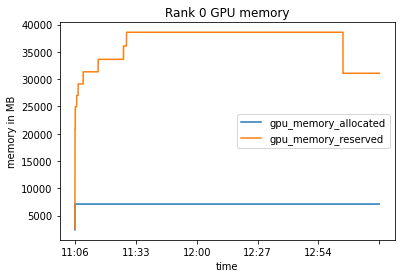

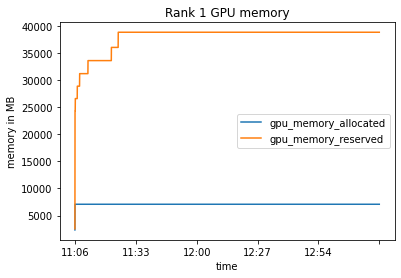

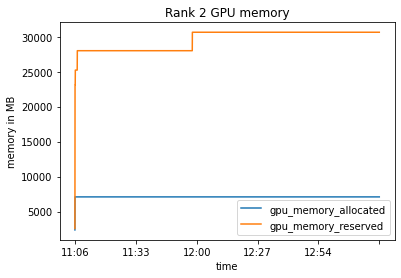

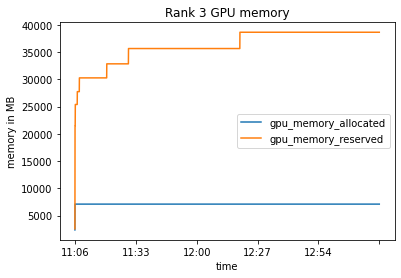

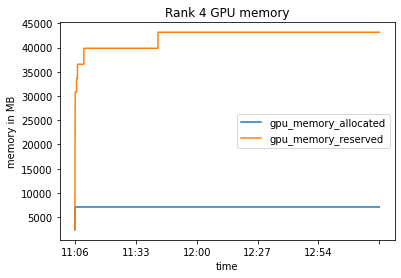

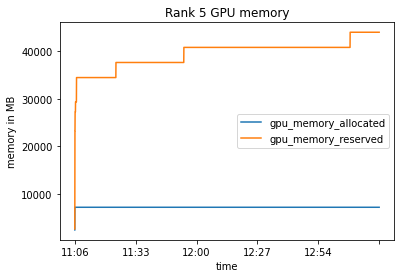

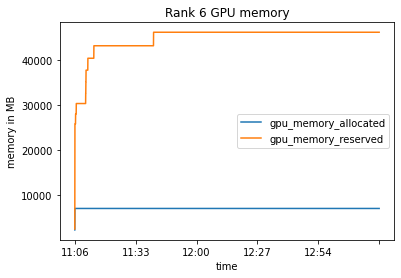

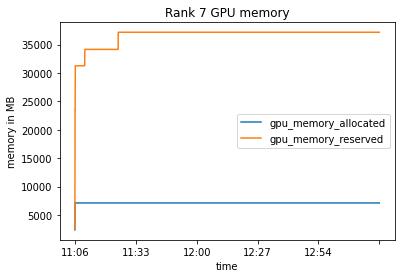

In [11]:
plot_cuda_memory(cuda_df, mode="individual")

## Comparison of different runs

For different runs, the allocated and reserved GPU CUDA memory can be compared using the function below.

In [12]:
def compare_cuda_memory_along_runs(runs) -> pd.DataFrame:
    """
    Compare cuda memory usage over all runs that are provided.
    """
    torch_cuda_paths = get_paths(runs, csv_type="torch_cuda")
    memory_runs = {}
    for key, run in runs.items():
        cuda_df = get_metrics_csv(torch_cuda_paths[key], csv_type="torch_cuda")
        memory_runs[key] = cuda_df[["gpu_memory_allocated", "gpu_memory_reserved"]].mean()
    return pd.DataFrame(memory_runs)

In [13]:
compare_cuda_memory_along_runs(runs)

,stage0,stage0_fp16,stage2,stage2_offloadOptimizer[cpu],stage3_offloadOptimizer[cpu]_offloadParam[cpu]
gpu_memory_allocated,7108.674418,7096.125152,2357.129914,1775.432378,2779.855518
gpu_memory_reserved,37922.405876,24924.734819,19214.518631,18713.886893,20971.450917
